In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from model import Hash2ImageModel
from data import Hash2ImgDataset
from hash import compute_hash, hash2tensor

from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
import argparse
import lpips

In [7]:
BATCH_SIZE = 1
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'

torch.manual_seed(1337)

# Using color images or not
rgb = True

# Create the dataset and data loader for training
if rgb:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

dataset = Hash2ImgDataset(image_paths='./celeba_data_photodna/val/images', hash_paths='./celeba_data_photodna/val/hashes.pkl', hash_func='photodna', transforms=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)
# Load the photodna model 
model_path = '/Users/neddamj/Documents/BU/Research/2022PhotoDNA/nnhash/inversion/saved_models/photodna_celeba_model.pth'
model = Hash2ImageModel(rgb=rgb, hash_func='photodna')
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model = model.eval()

# Load the pdq model 
model_path = '/Users/neddamj/Documents/BU/Research/2022PhotoDNA/nnhash/inversion/saved_models/pdq_celeba_model.pth'
pdq_model = Hash2ImageModel(rgb=rgb, hash_func='pdq')
checkpoint = torch.load(model_path)
pdq_model.load_state_dict(checkpoint['model_state_dict'])
pdq_model.to(DEVICE)
pdq_model = pdq_model.eval()

# Load the neuralhash model 
model_path = '/Users/neddamj/Documents/BU/Research/2022PhotoDNA/nnhash/inversion/saved_models/neuralhash_celeba_model.pth'
nn_model = Hash2ImageModel(rgb=rgb, hash_func='neuralhash')
checkpoint = torch.load(model_path)
nn_model.load_state_dict(checkpoint['model_state_dict'])
nn_model.to(DEVICE)
nn_model = nn_model.eval()

In [44]:
def invert_photodna(num):
    for i, (hash, image) in enumerate(loader):
        hash, image = hash.to(DEVICE), image.to(DEVICE)
        with torch.no_grad():
            pred_img = model(hash)   
        pred_img = pred_img.to(torch.device('cpu'))
        pred_img = pred_img.squeeze(0).detach().permute(1, 2, 0)
        image = image.to(torch.device('cpu'))
        image = image.squeeze(0).detach().permute(1, 2, 0)
        if i == num-1:
            break
    return (image + 1)/2, (pred_img+1)/2

def invert_pdq(num):
    pdq_hash = compute_hash(f'/Users/neddamj/Documents/BU/Research/2022PhotoDNA/nnhash/inversion/celeba_data_photodna/val/images/{num}.jpeg', hash_func='pdq')
    with torch.no_grad():
        tensor = hash2tensor(pdq_hash.copy(), hash_func='pdq').unsqueeze(0)
        pred_img = pdq_model(tensor.to(DEVICE))
    pred_img = pred_img.to(torch.device('cpu'))
    pred_img = pred_img.squeeze(0).detach().permute(1, 2, 0)
    return (pred_img+1)/2

def invert_neuralhash(num):
    nn_hash = compute_hash(f'/Users/neddamj/Documents/BU/Research/2022PhotoDNA/nnhash/inversion/celeba_data_photodna/val/images/{num}.jpeg', hash_func='neuralhash')
    with torch.no_grad():
        pred_img = nn_model(hash2tensor(nn_hash, hash_func='neuralhash').unsqueeze(0).to(DEVICE))
    pred_img = pred_img.to(torch.device('cpu'))
    pred_img = pred_img.squeeze(0).detach().permute(1, 2, 0)
    return (pred_img+1)/2

In [36]:
def plot_inversions(image, photo_img, pdq_img, nn_img):
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(photo_img)
    plt.title('PhotoDNA')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(pdq_img)
    plt.title('PDQ')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(nn_img)
    plt.title('NeuralHash')
    plt.axis('off')

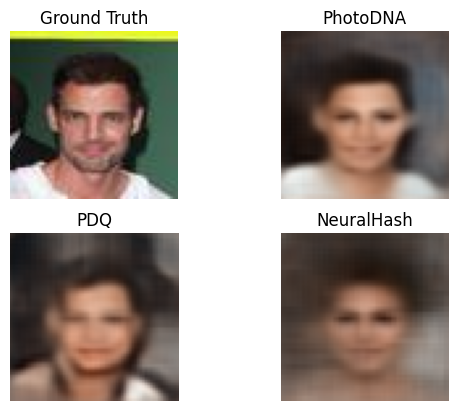

In [45]:
# 27 and 32
image_num = 6
image, photo_img = invert_photodna(image_num)
pdq_img = invert_pdq(image_num)
nn_img = invert_neuralhash(image_num)
plot_inversions(image, photo_img, pdq_img, nn_img)

In [25]:
perceptual_sim = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /Users/neddamj/miniforge3/envs/nhash/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [26]:
print('PhotoDNA')
l2_dist = np.linalg.norm(image - photo_img)/np.sqrt(64*64*3)
print(f'L2 Distance: {l2_dist}')
# Find the SSIM between the original and geneerated images
ssim_score = ssim(np.array(image), np.array(photo_img), channel_axis=-1, data_range=1)
print(f'SSIM Score: {ssim_score}')
# Calculate the perceptual similarity
image, photo_img = image.permute(2, 0, 1), photo_img.permute(2, 0, 1)
d = perceptual_sim(image, photo_img, normalize=True)
print(f'LPIPS Score: {d.detach().numpy()}')
image, photo_img = image.permute(1, 2, 0), photo_img.permute(1, 2, 0)

PhotoDNA
L2 Distance: 0.14408286987443475
SSIM Score: 0.6488508582115173
LPIPS Score: [[[[0.34298986]]]]


In [27]:
print('PDQ')
l2_dist = np.linalg.norm(image - pdq_img)/np.sqrt(64*64*3)
print(f'L2 Distance: {l2_dist}')
# Find the SSIM between the original and geneerated images
ssim_score = ssim(np.array(image), np.array(pdq_img), channel_axis=-1, data_range=1)
print(f'SSIM Score: {ssim_score}')
# Calculate the perceptual similarity
image, pdq_img = image.permute(2, 0, 1), pdq_img.permute(2, 0, 1)
d = perceptual_sim(image, pdq_img, normalize=True)
print(f'LPIPS Score: {d.detach().numpy()}')
image, pdq_img = image.permute(1, 2, 0), pdq_img.permute(1, 2, 0)

PDQ
L2 Distance: 0.14762025187412062
SSIM Score: 0.6018632054328918
LPIPS Score: [[[[0.36104962]]]]


In [28]:
print('NeuralHash')
l2_dist = np.linalg.norm(image - nn_img)/np.sqrt(64*64*3)
print(f'L2 Distance: {l2_dist}')
# Find the SSIM between the original and geneerated images
ssim_score = ssim(np.array(image), np.array(nn_img), channel_axis=-1, data_range=1)
print(f'SSIM Score: {ssim_score}')
# Calculate the perceptual similarity
image, nn_img = image.permute(2, 0, 1), nn_img.permute(2, 0, 1)
d = perceptual_sim(image, nn_img, normalize=True)
print(f'LPIPS Score: {d.detach().numpy()}')

NeuralHash
L2 Distance: 0.1956124042155934
SSIM Score: 0.3994280993938446
LPIPS Score: [[[[0.49721882]]]]
